<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/HW2_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tf-nightly-2.0-preview

# Part 1

**Tianbo Qiu (tq2137)**

In [0]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3

print(tf.__version__)

2.0.0-dev20190214


In [0]:
!wget https://storage.googleapis.com/applied-dl/mini_flowers.zip \
  -O /tmp/mini_flowers.zip

--2019-02-14 22:44:43--  https://storage.googleapis.com/applied-dl/mini_flowers.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 2a00:1450:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40110537 (38M) [application/zip]
Saving to: ‘/tmp/mini_flowers.zip’

/tmp/mini_flowers.z 100%[===================>]  38.25M  24.2MB/s    in 1.6s    

2019-02-14 22:44:45 (24.2 MB/s) - ‘/tmp/mini_flowers.zip’ saved [40110537/40110537]



In [0]:
# Data
local_zip = '/tmp/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/mini_flowers')
zip_ref.close()
base_dir = '/tmp/mini_flowers'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
n_classes = len(os.listdir(train_dir))
train_paths = [os.path.join(train_dir, i) for i in os.listdir(train_dir)]
val_paths = [os.path.join(val_dir, i) for i in os.listdir(val_dir)]
n_train = sum([len(os.listdir(i)) for i in train_paths])
n_val = sum([len(os.listdir(i)) for i in val_paths])
data_gen = ImageDataGenerator(rescale=1./255)
BATCH_SIZE=32
TARGET_SHAPE=150
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                         directory=train_dir,
                                         shuffle=True,
                                         target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                         class_mode='categorical')
val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                         directory=val_dir,
                                         shuffle=True,
                                         target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                         class_mode='categorical')



Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
batch_train_images, batch_train_labels = next(train_data)
batch_train_images.shape
batch_train_labels[4]
train_data.batch_size

32

In [0]:
# feature extraction
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

def extract_features(data_gen, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count,5))
  i = 0
  BATCH_SIZE = data_gen.batch_size
  for images_batch, labels_batch in data_gen:
    features[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = conv_base.predict(images_batch)
    labels[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = labels_batch
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
    return features, labels
train_features, train_labels = extract_features(train_data, n_train)
val_features, val_labels = extract_features(val_data, n_val)

In [0]:
print(train_features.shape)
print(train_labels.shape)

(1000, 4, 4, 512)
(1000, 5)


In [0]:
# Model
train_features = np.reshape(train_features, (n_train, 4*4*512))
val_features = np.reshape(val_features, (n_val, 4*4*512))
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(5, activation = 'sigmoid'))

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
history = model.fit(train_features, train_labels, epochs=20,batch_size=32, validation_data=(val_features, val_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/20
1000/1000==============================] - 1s 875us/sample - loss: 0.0759 - acc: 0.0720 - val_loss: 0.0976 - val_acc: 0.0160
Epoch 2/20
1000/1000==============================] - 1s 661us/sample - loss: 0.0510 - acc: 0.3510 - val_loss: 0.1022 - val_acc: 0.9520
Epoch 3/20
1000/1000==============================] - 1s 675us/sample - loss: 0.0437 - acc: 0.3890 - val_loss: 0.1694 - val_acc: 0.0160
Epoch 4/20
1000/1000==============================] - 1s 666us/sample - loss: 0.0630 - acc: 0.6360 - val_loss: 0.2483 - val_acc: 0.9540
Epoch 5/20
1000/1000==============================] - 1s 659us/sample - loss: 0.0523 - acc: 0.9750 - val_loss: 0.1409 - val_acc: 0.9500
Epoch 6/20
1000/1000==============================] - 1s 660us/sample - loss: 0.0397 - acc: 0.9750 - val_loss: 0.1432 - val_acc: 0.9500
Epoch 7/20
1000/1000==============================] - 1s 657us/sample - loss: 0.0407 - acc: 0.9410 - val_loss: 0.1276 - val_acc: 0.9540
E

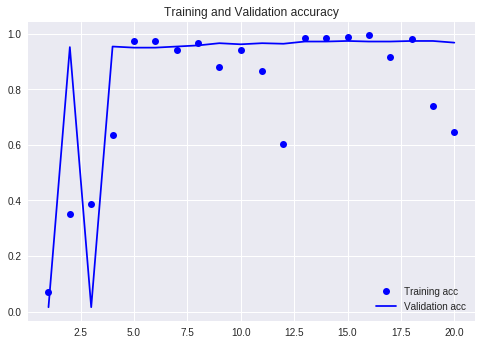

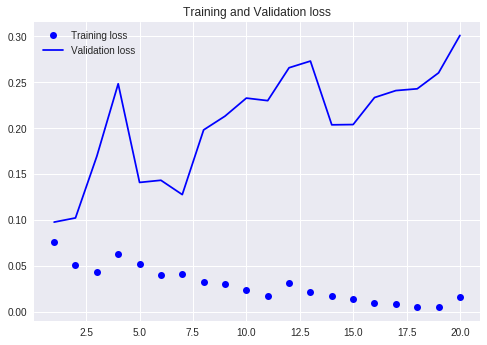

In [0]:
# Plotting the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


**The validation accuracy is 96.80% in this model.**

**Part 1.2**

In [0]:
def extract_features_for_ResNet50(data_gen, sample_count):
  features = np.zeros(shape=(sample_count, 5, 5, 2048))
  labels = np.zeros(shape=(sample_count,5))
  i = 0
  BATCH_SIZE = data_gen.batch_size
  for images_batch, labels_batch in data_gen:
    features[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = conv_base.predict(images_batch)
    labels[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = labels_batch
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
    return features, labels
train_features, train_labels = extract_features_for_ResNet50(train_data, n_train)
val_features, val_labels = extract_features_for_ResNet50(val_data, n_val)
train_features = np.reshape(train_features, (n_train, 5 * 5 * 2048))
val_features = np.reshape(val_features, (n_val, 5 * 5 * 2048))

In [0]:
# Transfer from ResNet50

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016==============================] - 4s 0us/step


In [0]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_dim=5*5*2048))
model2.add(keras.layers.Dropout(0.5))
model2.add(Dense(5, activation='sigmoid'))
model2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])
checkpoint_path = 'training/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                verbose = 1,
                                                save_weights_only=True,
                                                period=1)
history2 = model2.fit(train_features, train_labels, epochs=20,batch_size=32,callbacks=[cp_callback], validation_data=(val_features, val_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/20
 992/1000============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.1280
Epoch 00001: saving model to training/cp-0001.ckpt
1000/1000==============================] - 5s 5ms/sample - loss: 0.1286 - acc: 0.1280 - val_loss: 0.1038 - val_acc: 0.0100
Epoch 2/20
 992/1000============================>.] - ETA: 0s - loss: 0.0735 - acc: 0.0060
Epoch 00002: saving model to training/cp-0002.ckpt
1000/1000==============================] - 4s 4ms/sample - loss: 0.0729 - acc: 0.0060 - val_loss: 0.1030 - val_acc: 0.0140
Epoch 3/20
 992/1000============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.1280
Epoch 00003: saving model to training/cp-0003.ckpt
1000/1000==============================] - 4s 4ms/sample - loss: 0.0520 - acc: 0.1280 - val_loss: 0.1030 - val_acc: 0.0180
Epoch 4/20
 992/1000============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.4163
Epoch 00004: saving model to training/cp-0004.ckpt
1000/1000=======

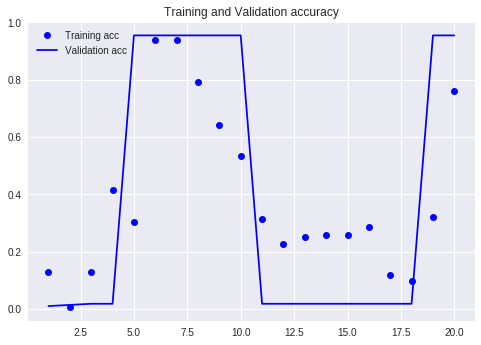

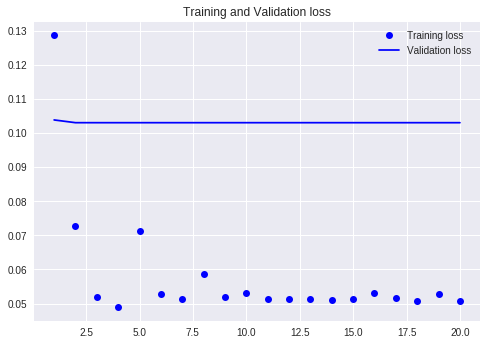

In [0]:
# Plotting the results
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
# Transfer from InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))


87916544/87910968==============================] - 6s 0us/step


In [0]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1[0][0]     
_______________________________________________________________________________________

In [0]:
len(conv_base.layers) #the network is very deep

311

In [0]:
def extract_features_for_InceptionV3(data_gen, sample_count):
  features = np.zeros(shape=(sample_count, 3, 3, 2048))
  labels = np.zeros(shape=(sample_count,5))
  i = 0
  BATCH_SIZE = data_gen.batch_size
  for images_batch, labels_batch in data_gen:
    features[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = conv_base.predict(images_batch)
    labels[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = labels_batch
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
    return features, labels
train_features, train_labels = extract_features_for_InceptionV3(train_data, n_train)
val_features, val_labels = extract_features_for_InceptionV3(val_data, n_val)
train_features = np.reshape(train_features, (n_train, 3 * 3 * 2048))
val_features = np.reshape(val_features, (n_val, 3 * 3 * 2048))

In [0]:
model3 = Sequential()
model3.add(Dense(256, activation='relu', input_dim=3*3*2048))
model3.add(keras.layers.Dropout(0.5))
model3.add(Dense(5, activation='sigmoid'))
model3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])
checkpoint_path = 'trainingV3/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                verbose = 1,
                                                save_weights_only=True,
                                                period=1)
history3 = model3.fit(train_features, train_labels, epochs=20,batch_size=32,callbacks=[cp_callback], validation_data=(val_features, val_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/20
 992/1000============================>.] - ETA: 0s - loss: 0.2110 - acc: 0.1623
Epoch 00001: saving model to trainingV3/cp-0001.ckpt
1000/1000==============================] - 1s 1ms/sample - loss: 0.2254 - acc: 0.1610 - val_loss: 0.4840 - val_acc: 0.0040
Epoch 2/20
 960/1000===========================>..] - ETA: 0s - loss: 0.2340 - acc: 0.0385
Epoch 00002: saving model to trainingV3/cp-0002.ckpt
1000/1000==============================] - 2s 2ms/sample - loss: 0.2246 - acc: 0.0370 - val_loss: 0.2360 - val_acc: 0.0060
Epoch 3/20
 960/1000===========================>..] - ETA: 0s - loss: 0.1956 - acc: 0.0219
Epoch 00003: saving model to trainingV3/cp-0003.ckpt
1000/1000==============================] - 2s 2ms/sample - loss: 0.1892 - acc: 0.0210 - val_loss: 0.4892 - val_acc: 0.0060
Epoch 4/20
 960/1000===========================>..] - ETA: 0s - loss: 0.2416 - acc: 0.1083
Epoch 00004: saving model to trainingV3/cp-0004.ckpt
1000/100

In [0]:
model3.load_weights('trainingV3/cp-0019.ckpt')
loss, acc = model3.evaluate(val_features, val_labels) # The highest accuracy we got is 94.20%

500/500==============================] - 0s 378us/sample - loss: 0.2320 - acc: 0.9420


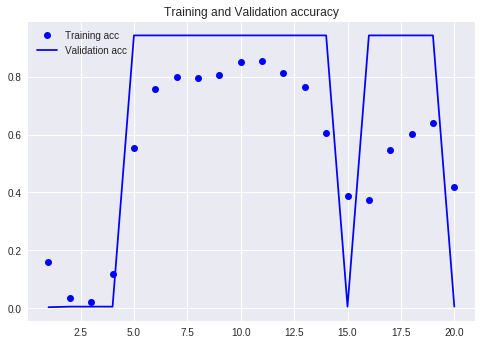

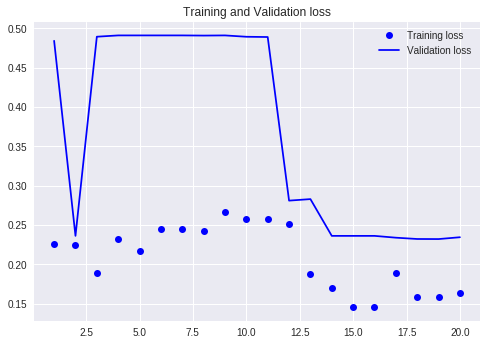

In [0]:
# Plotting the results
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

##Comparison
$\bullet$ **accuracy** $VGG16 : 96.80\%, ResNet50 : 95.40\%, InceptionV3 : 94.20\%$

$\bullet$ When deeper conv_base is used, it takes longer for the model to overfit. 

$\bullet$ We can also see that the deeper model has less accuracy, probably because the deeper model learned more abstract features and needs more data for training.

# Part 2

In [0]:
!pip install -q tf-nightly-2.0-preview
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3


In [0]:
print(tf.__version__)

2.0.0-dev20190227


In [0]:
# Prepare the dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
base_dir = 'drive/My\ Drive'
base_dir = os.path.join(base_dir, 'DeepLearning')
base_dir = os.path.join(base_dir, 'COLUMBIA_STATUES')

In [0]:
% cd $base_dir

/content/drive/My Drive/DeepLearning/COLUMBIA_STATUES


In [0]:
base_dir.split('/')

['drive', 'My\\ Drive', 'DeepLearning', 'COLUMBIA_STATUES']

In [0]:
# directory tree

--COLUMBIA_STATUES/

        --train/
              --AlmaMater/
              --Lion/
              --Thinker/
              --TightropeWalker/
              --Hamilton/
              --Jerfferson/
        --val/
               --AlmaMater/
              --Lion/
              --Thinker/
              --TightropeWalker/
              --Hamilton/
              --Jerfferson/
        --test/
              --AlmaMater/
              --Lion/
              --Thinker/
              --TightropeWalker/
              --Hamilton/
              --Jerfferson/

In [0]:
# There are 6 classes
# 200 images for training, 70 for validation, and 30 for test
# for each class

In [67]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

n_train = 200
n_val = 70
n_test = 30

n_classes = 6
TARGET_SHAPE = 150
BATCH_SIZE = 10
train_data_gen = ImageDataGenerator(rescale=1./255)
val_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                               class_mode='categorical')
val_data = val_data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=val_dir,
                                               shuffle=True,
                                               target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                               class_mode='categorical')
test_data = test_data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=test_dir,
                                               shuffle=True,
                                               target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                               class_mode='categorical')

Found 1200 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


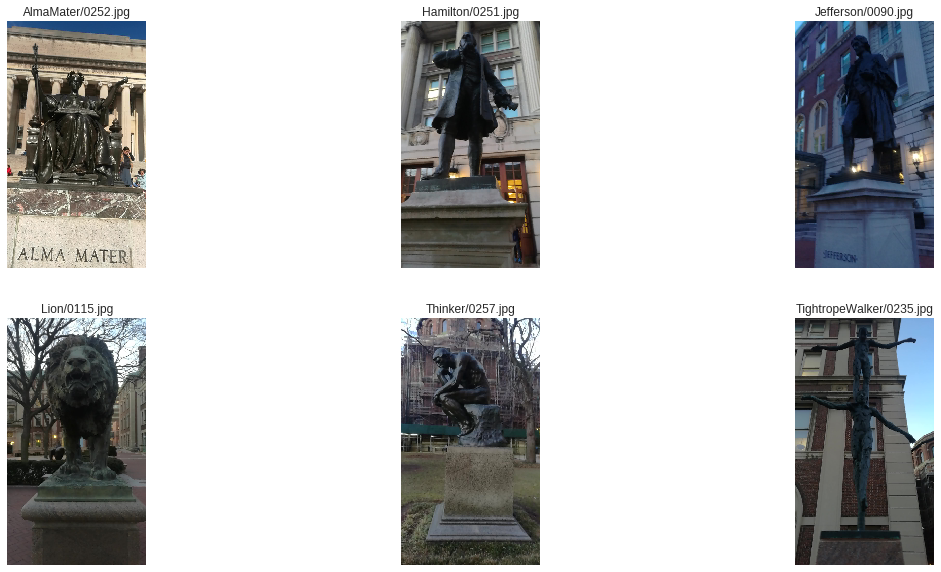

In [105]:
from numpy.random import choice
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plt.figure(figsize=(20,10))
for i in range(6):
  id = np.random.choice(range(i*200, (i+1)*200), 1)[0]
  filename = train_data.filenames[id]
  path = os.path.join('train', filename)
  img = mpimg.imread(path)
  plt.subplot(2,3,i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.title(filename)
  plt.imshow(img)
  
  
               

In [106]:
# Deep Model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

58892288/58889256 [==============================] - 1s 0us/step


In [107]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
def extract_features_fromVGG16(data_from_gen, n):
  BATCH_SIZE=data_from_gen.batch_size
  n_classes = len(data_from_gen.class_indices)
  features = np.zeros(shape=(n,4,4,512))
  labels = np.zeros(shape=(n, n_classes))
  
  i = 0
  for images_batch, labels_batch in data_from_gen:
    features[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = conv_base.predict(images_batch)
    labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = labels_batch
    print('Bacth{}/{} Done'.format(i+1, int(n/BATCH_SIZE)))
    i += 1
    if i * BATCH_SIZE >= n:
      break
  return features, labels

In [114]:
train_features, train_labels = extract_features_fromVGG16(train_data, 6*200)

Bacth1/120 Done
Bacth2/120 Done
Bacth3/120 Done
Bacth4/120 Done
Bacth5/120 Done
Bacth6/120 Done
Bacth7/120 Done
Bacth8/120 Done
Bacth9/120 Done
Bacth10/120 Done
Bacth11/120 Done
Bacth12/120 Done
Bacth13/120 Done
Bacth14/120 Done
Bacth15/120 Done
Bacth16/120 Done
Bacth17/120 Done
Bacth18/120 Done
Bacth19/120 Done
Bacth20/120 Done
Bacth21/120 Done
Bacth22/120 Done
Bacth23/120 Done
Bacth24/120 Done
Bacth25/120 Done
Bacth26/120 Done
Bacth27/120 Done
Bacth28/120 Done
Bacth29/120 Done
Bacth30/120 Done
Bacth31/120 Done
Bacth32/120 Done
Bacth33/120 Done
Bacth34/120 Done
Bacth35/120 Done
Bacth36/120 Done
Bacth37/120 Done
Bacth38/120 Done
Bacth39/120 Done
Bacth40/120 Done
Bacth41/120 Done
Bacth42/120 Done
Bacth43/120 Done
Bacth44/120 Done
Bacth45/120 Done
Bacth46/120 Done
Bacth47/120 Done
Bacth48/120 Done
Bacth49/120 Done
Bacth50/120 Done
Bacth51/120 Done
Bacth52/120 Done
Bacth53/120 Done
Bacth54/120 Done
Bacth55/120 Done
Bacth56/120 Done
Bacth57/120 Done
Bacth58/120 Done
Bacth59/120 Done
Bacth6

In [115]:
print(train_features.shape)
print(train_labels.shape)

(1200, 4, 4, 512)
(1200, 6)


In [116]:
val_data = val_data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                           directory=val_dir,
                                           shuffle=True,
                                           target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                           class_mode='categorical')
val_features, val_labels = extract_features_fromVGG16(val_data, 6*70)

Found 420 images belonging to 6 classes.
Bacth1/42 Done
Bacth2/42 Done
Bacth3/42 Done
Bacth4/42 Done
Bacth5/42 Done
Bacth6/42 Done
Bacth7/42 Done
Bacth8/42 Done
Bacth9/42 Done
Bacth10/42 Done
Bacth11/42 Done
Bacth12/42 Done
Bacth13/42 Done
Bacth14/42 Done
Bacth15/42 Done
Bacth16/42 Done
Bacth17/42 Done
Bacth18/42 Done
Bacth19/42 Done
Bacth20/42 Done
Bacth21/42 Done
Bacth22/42 Done
Bacth23/42 Done
Bacth24/42 Done
Bacth25/42 Done
Bacth26/42 Done
Bacth27/42 Done
Bacth28/42 Done
Bacth29/42 Done
Bacth30/42 Done
Bacth31/42 Done
Bacth32/42 Done
Bacth33/42 Done
Bacth34/42 Done
Bacth35/42 Done
Bacth36/42 Done
Bacth37/42 Done
Bacth38/42 Done
Bacth39/42 Done
Bacth40/42 Done
Bacth41/42 Done
Bacth42/42 Done


In [117]:
print(val_features.shape)
print(val_labels.shape)

(420, 4, 4, 512)
(420, 6)


In [118]:
test_features, test_labels = extract_features_fromVGG16(test_data, 6*30)

Bacth1/18 Done
Bacth2/18 Done
Bacth3/18 Done
Bacth4/18 Done
Bacth5/18 Done
Bacth6/18 Done
Bacth7/18 Done
Bacth8/18 Done
Bacth9/18 Done
Bacth10/18 Done
Bacth11/18 Done
Bacth12/18 Done
Bacth13/18 Done
Bacth14/18 Done
Bacth15/18 Done
Bacth16/18 Done
Bacth17/18 Done
Bacth18/18 Done


In [0]:
# Model
# transfer learning
# flatten layer
train_features = np.reshape(train_features, (1200, 4*4*512))
val_features   = np.reshape(val_features, (420, 4*4*512))
test_features = np.reshape(test_features, (180, 4*4*512))

In [128]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(keras.layers.Dropout(0.2))
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=30, batch_size=10,
                   validation_data=(val_features, val_labels))

Train on 1200 samples, validate on 420 samples
Epoch 1/30
1200/1200 [==============================] - 2s 2ms/sample - loss: 0.2220 - acc: 0.8833 - val_loss: 2.3912e-05 - val_acc: 1.0000
Epoch 2/30
1200/1200 [==============================] - 2s 2ms/sample - loss: 0.0016 - acc: 0.9992 - val_loss: 9.3123e-06 - val_acc: 1.0000
Epoch 3/30
1200/1200 [==============================] - 2s 2ms/sample - loss: 3.3225e-04 - acc: 1.0000 - val_loss: 1.8743e-05 - val_acc: 1.0000
Epoch 4/30
1200/1200 [==============================] - 2s 2ms/sample - loss: 1.2728e-04 - acc: 1.0000 - val_loss: 3.0102e-06 - val_acc: 1.0000
Epoch 5/30
1200/1200 [==============================] - 2s 2ms/sample - loss: 1.7653e-04 - acc: 1.0000 - val_loss: 4.2742e-06 - val_acc: 1.0000
Epoch 6/30
1200/1200 [==============================] - 2s 2ms/sample - loss: 9.6606e-05 - acc: 1.0000 - val_loss: 2.1329e-06 - val_acc: 1.0000
Epoch 7/30
1200/1200 [==============================] - 2s 2ms/sample - loss: 1.3444e-04 - acc: 1

In [137]:
acc = tf.keras.metrics.categorical_accuracy
test_acc = acc(model.predict(test_features), test_labels)
test_acc = tf.reduce_mean(test_acc)
print('Test Accuracy: {}'.format(test_acc))

Test Accuracy: 1.0


**Report of the result: **

The model can achieve a test accuracy of 100% by transfer learning and is based on VGG-16 model. I recorded a video for each landmark and split the video into frames. Then I shuffle the images and randomly pick 200 for training, 70 for validation, and 30 for test for each class. When I recorded the video, I moved back and forth and filmed at different angles, and actually I think the Hamilton statue and Jefferson statue looks quite similar. However, the model can still achieved 100% accuracy on test set, which means that the model has the capability to memorize the training set, and the test and validation set are probably too small to show its overfitting.
